In [1]:
# default_exp analyses

# The Spacing Effect
> "The beneficial mnemonic effects of spaced over massed learning is one of the most widely documented and well studied memory phenomena. Although it is seen in a wide range of tasks, the spacing effect is particularly strong in free recall, where the probability of recalling a repeated word often increases monotonically to spacings of 20 or more items (Cepeda, Pashler, Vul, Wixted, & Rohrer, 2006; Delaney, Verkoeijen, & Spirgel, 2010; Donovan & Radosevich, 1999; Madigan, 1969; Melton, 1970)." - Lohnas & Kahana, 2014

## Function

In [20]:
# export

from numba import njit, prange
import numpy as np

#@njit(nogil=True, parallel=True)
def recall_probability_by_lag(study_positions_in_recall_order, presentations, max_lag=8):

    total_presented, total_retrieved = np.zeros(max_lag+2), np.zeros(max_lag+2)

    for trial_index in prange(len(presentations)):

        # nested accumulation to ensure parallelization doesn't cause problems
        presented, retrieved = np.zeros(max_lag+2), np.zeros(max_lag+2)
            
        # extract sequence of presentations
        presentation = presentations[trial_index]

        # extract sequence of responses
        responses = study_positions_in_recall_order[trial_index]
        responses = responses[responses > 0]-1

        # for each studied_item in presentation, identify its presentation positions
        for studied_item in np.unique(presentation):

            # identify occurrences of item index in presentation vector
            item_occurrences = np.where(presentation == studied_item)[0]

            # convert to incremental distances
            lags = item_occurrences[1:] - item_occurrences[:-1]
            
            # aggregate to select bin for accumulation
            index = 0 if lags.size == 0 else np.int64(np.mean(lags))

            # accumulate
            presented[index] += 1
            retrieved[index] += item_occurrences[0] in responses

        total_presented += presented
        total_retrieved += retrieved

    return total_retrieved/total_presented

## Plotting
We'll perform the analysis on each subject's data separately so we can compute error bars, and aggregate the results into a pandas dataframe.

In [2]:
# export

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from compmemlearn.datasets import events_metadata, generate_trial_mask

def plot_trial_recall_probability_by_lag(
    data, trial_query, contrast_name='', labels=None, axis=None, rigid=True):

    if axis is None:
        plt.figure()
        axis = plt.gca()

    if labels is None:
        labels = [''] * len(data)

    result = []
    for data_index, events in enumerate(data):

        # generate and subset trials array and list of list_lengths based on trial_query
        trials, list_lengths, presentations = events_metadata(events)
        trial_mask = generate_trial_mask(events, trial_query)
        chose = [i for i in range(len(trial_mask)) if np.sum(trial_mask[i]) != 0]
        assert(len(chose) == 1)
        chose = chose[0]
        trial_mask = trial_mask[chose]
        trials = trials[chose][trial_mask]
        list_length = list_lengths[chose]
        presentations = presentations[chose][trial_mask]

        # use static parameters depending on dataset if we've allowed rigid to be True
        if rigid:
            if np.sum(presentations[0][0] == presentations[0]) > 2:
                repetition_count = 3
                max_lag = 20
            else:
                repetition_count = 2
                max_lag = 8
        if max_lag != 8 and max_lag != 20:
            raise ValueError("plot_recall_probability_by_lag currently only supports max_lag of 8 or 20")

        for trial_index, trial in enumerate(trials):

            trial_result = recall_probability_by_lag(
                np.expand_dims(trial, 0), np.expand_dims(presentations[trial_index], 0),  max_lag=max_lag)
            assert(np.all(np.isnan(trial_result[:3])))

            if np.sum(trial_result) == 0:
                continue

            binned = []
            xlabels = []
            if max_lag == 8:
                binned.append(trial_result[0]) # N/A
                binned.append(trial_result[1]) # massed repetition
                binned.append(np.nanmean(trial_result[2:4])) # lag of 1-2
                binned.append(np.nanmean(trial_result[4:7])) # lag of 3-5
                binned.append(np.nanmean(trial_result[7:10])) # lag of 6-8
                xlabels = ['N/A', '0', '1-2', '3-5', '6-8']
            else:
                binned.append(trial_result[0]) # N/A
                binned.append(np.nanmean(trial_result[1:3])) # massed repetition
                binned.append(np.nanmean(trial_result[3:6])) # lag of 2, 3, 4
                binned.append(np.nanmean(trial_result[6:9])) # lag of 5, 6, 7
                binned.append(np.nanmean(trial_result[9:12])) # lag of 8, 9, 10
                binned.append(np.nanmean(trial_result[12:15])) # lag of 11, 12, 13
                binned.append(np.nanmean(trial_result[15:18])) # lag of 14, 15, 16
                binned.append(np.nanmean(trial_result[18:21])) # lag of 17, 18, 19, 20
                xlabels = ['N/A', '0-1', '2-4', '5-7', '8-10', '11-13', '14-16', '17-19']
            
            
            #xlabels = [xlabels[i] for i in range(len(xlabels)) if not np.isnan(binned[i])]
            #binned = [b for b in binned if not np.isnan(b)]
            result.append(pd.DataFrame.from_dict(
                {
                    "lag": xlabels,
                    "recall": binned,
                    contrast_name: labels[data_index],
                }
            ))

    result = pd.concat(result)

    sns.pointplot(ax=axis, data=result, x='lag', y='recall', hue=contrast_name) #, err_style='bars')
    axis.set(xlabel='Lag Between Presentations', ylabel='Recall Rate')
    #axis.set_xticks(np.arange(0, list_length+int(list_length/10), int(list_length/10)))
    #axis.set_ylim((0, 1))

    if contrast_name:
        axis.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    else:
        plt.legend([],[], frameon=False)

    return axis

In [10]:
# export

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from compmemlearn.datasets import events_metadata, generate_trial_mask

def plot_recall_probability_by_lag(data, trial_query, contrast_name='', labels=None, axis=None, rigid=True):

    if axis is None:
        plt.figure()
        axis = plt.gca()

    if labels is None:
        labels = [''] * len(data)

    result = []
    for data_index, events in enumerate(data):

        # generate and subset trials array and list of list_lengths based on trial_query
        trials, list_lengths, presentations = events_metadata(events)
        trial_mask = generate_trial_mask(events, trial_query)
        chose = [i for i in range(len(trial_mask)) if np.sum(trial_mask[i]) != 0]
        assert(len(chose) == 1)
        chose = chose[0]
        trials = trials[chose]
        list_length = list_lengths[chose]
        presentations = presentations[chose]
        trial_mask = trial_mask[chose]

        # use static parameters depending on dataset if we've allowed rigid to be True
        if rigid:
            if np.sum(presentations[0][0] == presentations[0]) > 2:
                repetition_count = 3
                max_lag = 19
            else:
                repetition_count = 2
                max_lag = 8
        if max_lag != 8 and max_lag != 19:
            raise ValueError("plot_recall_probability_by_lag currently only supports max_lag of 8 or 19")

        for subject in pd.unique(events.subject):

            subject_specific_trial_mask = np.logical_and(
                generate_trial_mask(events, f"subject == {subject}")[chose], trial_mask
            )

            if np.sum(subject_specific_trial_mask) == 0:
                continue

            subject_result = recall_probability_by_lag(
                trials[subject_specific_trial_mask], presentations[subject_specific_trial_mask], max_lag=max_lag)

            binned = []
            xlabels = ['N/A', '0', '1-2', '3-5', '6-8']
            binned.append(subject_result[0]) # N/A
            binned.append(subject_result[1]) # massed repetition
            binned.append(np.nanmean(subject_result[2:4])) # lag of 1-2
            binned.append(np.nanmean(subject_result[4:7])) # lag of 3-5
            binned.append(np.nanmean(subject_result[7:10])) # lag of 6-8
            if max_lag > 8:
                xlabels.append('9+')
                binned.append(np.nanmean(subject_result[10:])) # lag of 9+
                # binned.append(subject_result[0]) # N/A
                # binned.append(np.nanmean(subject_result[1:3])) # lag of 0, 1
                # binned.append(np.nanmean(subject_result[3:6])) # lag of 2, 3, 4
                # binned.append(np.nanmean(subject_result[6:9])) # lag of 5, 6, 7
                # binned.append(np.nanmean(subject_result[9:12])) # lag of 8, 9, 10
                # binned.append(np.nanmean(subject_result[12:15])) # lag of 11, 12, 13
                # binned.append(np.nanmean(subject_result[15:18])) # lag of 14, 15, 16
                # binned.append(np.nanmean(subject_result[18:21])) # lag of 17, 18, 19
                # xlabels = ['N/A', '0-1', '2-4', '5-7', '8-10', '11-13', '14-16', '17-19']
            
            
            #xlabels = [xlabels[i] for i in range(len(xlabels)) if not np.isnan(binned[i])]
            #binned = [b for b in binned if not np.isnan(b)]
            result.append(pd.DataFrame.from_dict(
                {
                    "subject": subject,
                    "lag": xlabels,
                    "recall": binned,
                    contrast_name: labels[data_index],
                }
            ))

    result = pd.concat(result)

    sns.pointplot(ax=axis, data=result, x='lag', y='recall', hue=contrast_name) #, err_style='bars')
    axis.set(xlabel='Lag Between Presentations', ylabel='Recall Rate')
    #axis.set_xticks(np.arange(0, list_length+int(list_length/10), int(list_length/10)))
    #axis.set_ylim((0, 1))

    if contrast_name:
        axis.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    else:
        plt.legend([],[], frameon=False)

    return axis

C:\Users\gunnj\AppData\Local\Temp\ipykernel_6232\1755524960.py:42: RuntimeWarning: invalid value encountered in true_divide
  return total_retrieved/total_presented


[       nan 0.31747475        nan 0.34175153 0.33896104 0.32182864
 0.34346505 0.37306202 0.34705882 0.37369792 0.34766119 0.38208617
 0.39018952 0.35162374 0.36267606 0.42324561 0.35549133 0.34013605
 0.38421053 0.35652174 0.45833333]
[nan, 0.31747474747474747, 0.3341804023618926, 0.3545286282086643, 0.36781509094542436, 0.36816310572129973, 0.3729576659788751, 0.3996885329265192]


No handles with labels found to put in legend.


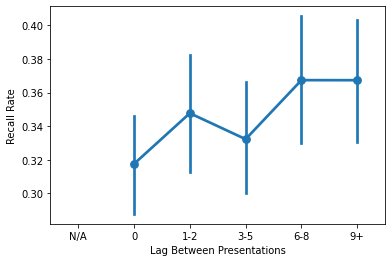

In [21]:
import pandas as pd
from compmemlearn.datasets import events_metadata, generate_trial_mask

events = pd.read_csv('../../../compmemlearn/data/HowardKahana2005.csv')
trials, list_lengths, presentations = events_metadata(events)

#for condition in [1, 2, 0]:
#trial_query = f"condition == {condition}"
trial_query = "condition > -1"
trial_mask = generate_trial_mask(events, trial_query)[0]
subject_result = recall_probability_by_lag(trials[0][trial_mask], presentations[0][trial_mask], max_lag=19)

binned = []
binned.append(subject_result[0]) # N/A
binned.append(np.nanmean(subject_result[1:3])) # lag of 0, 1
binned.append(np.nanmean(subject_result[3:6])) # lag of 2, 3, 4
binned.append(np.nanmean(subject_result[6:9])) # lag of 5, 6, 7
binned.append(np.nanmean(subject_result[9:12])) # lag of 8, 9, 10
binned.append(np.nanmean(subject_result[12:15])) # lag of 11, 12, 13
binned.append(np.nanmean(subject_result[15:18])) # lag of 14, 15, 16
binned.append(np.nanmean(subject_result[18:21])) # lag of 17, 18, 19
xlabels = ['N/A', '0-1', '2-4', '5-7', '8-10', '11-13', '14-16', '17-19']
print(subject_result)
print(binned)

plot_recall_probability_by_lag([events], trial_query, contrast_name='', labels=None, axis=None)
plt.show()
print()

[0.37278912 0.43928571 0.48928571 0.46428571 0.54642857 0.55357143
 0.57142857 0.54285714 0.61428571 0.57857143]
[0.3727891156462585, 0.4392857142857143, 0.47678571428571426, 0.5571428571428572, 0.5785714285714286]


No handles with labels found to put in legend.


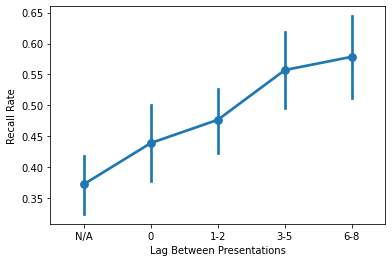

C:\Users\gunnj\AppData\Local\Temp\ipykernel_6232\1755524960.py:42: RuntimeWarning: invalid value encountered in true_divide
  return total_retrieved/total_presented


[       nan        nan 0.59451659 0.64721311 0.61363636 0.63507109
 0.63583815 0.63235294 0.64763231 0.6577381 ]
[nan, nan, 0.6208648546353465, 0.6281818679909248, 0.6459077827974272]


No handles with labels found to put in legend.


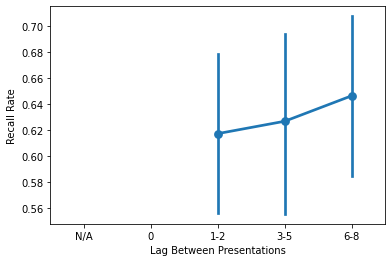

C:\Users\gunnj\AppData\Local\Temp\ipykernel_6232\1755524960.py:42: RuntimeWarning: invalid value encountered in true_divide
  return total_retrieved/total_presented
C:\Users\gunnj\AppData\Local\Temp\ipykernel_6232\2657796030.py:58: RuntimeWarning: Mean of empty slice
  binned.append(np.nanmean(subject_result[2:4])) # lag of 1-2
C:\Users\gunnj\AppData\Local\Temp\ipykernel_6232\2657796030.py:59: RuntimeWarning: Mean of empty slice
  binned.append(np.nanmean(subject_result[4:7])) # lag of 3-5
C:\Users\gunnj\AppData\Local\Temp\ipykernel_6232\2657796030.py:60: RuntimeWarning: Mean of empty slice
  binned.append(np.nanmean(subject_result[7:10])) # lag of 6-8


[       nan 0.59738095        nan        nan        nan        nan
        nan        nan        nan        nan]
[nan, 0.5973809523809523, nan, nan, nan]


No handles with labels found to put in legend.


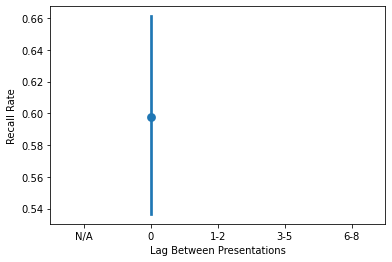

C:\Users\gunnj\AppData\Local\Temp\ipykernel_6232\1755524960.py:42: RuntimeWarning: invalid value encountered in true_divide
  return total_retrieved/total_presented
C:\Users\gunnj\AppData\Local\Temp\ipykernel_6232\2657796030.py:58: RuntimeWarning: Mean of empty slice
  binned.append(np.nanmean(subject_result[2:4])) # lag of 1-2
C:\Users\gunnj\AppData\Local\Temp\ipykernel_6232\2657796030.py:59: RuntimeWarning: Mean of empty slice
  binned.append(np.nanmean(subject_result[4:7])) # lag of 3-5
C:\Users\gunnj\AppData\Local\Temp\ipykernel_6232\2657796030.py:60: RuntimeWarning: Mean of empty slice
  binned.append(np.nanmean(subject_result[7:10])) # lag of 6-8


[0.35446429        nan        nan        nan        nan        nan
        nan        nan        nan        nan]
[0.35446428571428573, nan, nan, nan, nan]


No handles with labels found to put in legend.


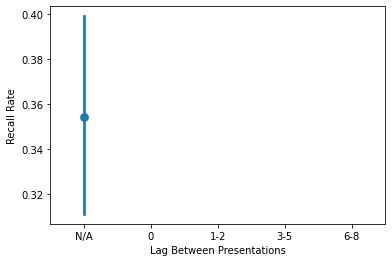

In [22]:
import pandas as pd
from compmemlearn.datasets import events_metadata, generate_trial_mask

events = pd.read_csv('../../../compmemlearn/data/LohnasKahana2014.csv')
trials, list_lengths, presentations = events_metadata(events)

for condition in [4, 3, 2, 1]:
    trial_mask = generate_trial_mask(events, f"condition == {condition}")[0]
    subject_result = recall_probability_by_lag(trials[0][trial_mask], presentations[0][trial_mask], max_lag=8)

    binned = []
    labels = []
    binned.append(subject_result[0]) # N/A
    binned.append(subject_result[1]) # massed repetition
    binned.append((subject_result[2] + subject_result[3])/2) # lag of 1-2
    binned.append((subject_result[4] + subject_result[5] + subject_result[6])/3) # lag of 3-5
    binned.append((subject_result[7] + subject_result[8] + subject_result[9])/3) # lag of 6-8
    print(subject_result)
    print(binned)

    plot_recall_probability_by_lag([events], f"condition == {condition}", contrast_name='', labels=None, axis=None)
    plt.show()
    print()